## Άσκηση 3: Βελτιστοποίηση συναρτήσεων με Γενετικούς Αλγόριθμους

Ορφανουδάκης Φίλιππος-Σκόβελεφ:03113140,

Μπακούρος Αριστείδης:03113138

Ομάδα Α5

## Μερος 1. Βελτιστοποίηση μη κλιμακούμενης συνάρτησης


Στόχος της άσκησης είναι η βελτιστοποίηση συναρτήσεων χωρίς παραγώγους (derivative free optimization) με χρήση Γενετικών Αλγόριθμων μέσω της βιβλιοθήκης DEAP. Η βελτιστοποίηση χωρίς παραγώγους είναι ιδιαίτερα χρήσιμη σε περιπτώσεις όπου η αντικειμενική συνάρτηση f δεν είναι διαθέσιμη (black-box optimization) ή σε περίπτωσεις που είναι, είναι δύσκολο ή μη πρακτικό να υπολογιστούν οι παράγωγοί της. Για παράδειγμα η ff μπορεί να μην είναι διαφορίσιμη, η παραγώγιση της μπορεί να είναι δύσκολη ή να απαιτεί πολύ χρόνο, η ff να περιέχει θόρυβο έτσι ώστε οι μέθοδοι που βασίζονται σε απειροστικές διαφορές να μην είναι αποτελεσματικές ή να υπάρχουν πολλά τοπικά ελάχιστα μεταξύ άλλων.

Η πρώτη συνάρτηση που θα μελετήσουμε είναι μη-κλιμακούμενη συνάρτηση (non-scalable, δηλαδή ορίζεται για συγκεκριμένες διαστάσεις του πεδίου ορισμού). Θα χρησιμοποιήσουμε ως γονίδια πραγματικούς αριθμούς και ως χρωμοσώματα λίστες γονιδίων μήκους ίσο με τη διάσταση του πεδίου ορισμού της συνάρτησης.

Η συνάρτηση της οποίας το ελάχιστο θέλουμε να βρούμε είναι η Ν.86 Pen Holder Function με τύπο στο [-11,11] :




In [0]:
from google.colab import files
from IPython.display import Image

In [122]:
uploaded=files.upload()

Saving pen1.PNG to pen1 (1).PNG


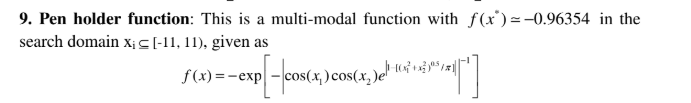

In [123]:
Image('pen1.PNG')

Κάνουμε τα απαραίτητα imports και φτιάχνουμε την κλάση Individual και Fitness που θα χρησιμοποιήσουμε για να κατασκευάσουμε το μέλος καταλληλότητας του κάθε ατόμου. Το βάρος που δίνουμε στην Fitness είναι -1.0, δηλαδή ελαχιστοποίηση ενός μεγέθους, στην προκειμένη περίπτωση του f(x1, x2). 
Στη συνέχεια φτιάχνουμε την κλάση του ατόμου το οποίο κληρονομεί από τον τύπο list και περιλαμβάνει το χαρακτηρηστικό FitnessMin και ελέγχουμε ένα ζευγάρι τιμών και τυπώνουμε ορισμένες τιμές για έλεγχο.

In [124]:
!pip install --upgrade pip
!pip install deap

Requirement already up-to-date: pip in /usr/local/lib/python2.7/dist-packages (19.0.3)


In [0]:
import math as mt
import numpy as np
from deap import algorithms
from math import *
from deap import base, creator

def penholder(x1,x2):
  tmp1 = 1 - mt.sqrt(x1**2 + x2**2)/mt.pi
  tmp2 = - mt.fabs(mt.cos(x1)*mt.cos(x2)*mt.exp(mt.fabs(tmp1)))**(-1)
  tmp3 = - mt.exp(tmp2)
  return tmp3

In [126]:
print(penholder(9.646168,9.646168))

-0.963534832727


In [0]:
creator.create("FitnessMin", base.Fitness , weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

Θα ορίσουμε τώρα μία συνάρτηση που θα ελέγχει την αποτελεσματικότητα ενός συνδυασμού.

In [0]:
import time
import random
from deap import tools

numVariables = 2  
PENALTY_DELTA = 10.0  
VERBOSE = False  
POPULATION = 13  
MIN_BOUND = np.array([-11]*numVariables)  
MAX_BOUND = np.array([11]*numVariables)


def feasible( indiv ):
    if any( indiv < MIN_BOUND) or any( indiv > MAX_BOUND):
        return False
    return True


def distance( indiv ) :
    dist = 0.0
    for i in range (len( indiv )) :
        penalty = 0
        if ( indiv [i] < MIN_BOUND[i]) : penalty = -11 - indiv [i]
        if ( indiv [i] > MAX_BOUND[i]) : penalty = indiv [i] - 11
        dist = dist + penalty
    return dist


def evalYFunc(ind):
    tmp1 = 1 - mt.sqrt(ind[0]**2 + ind[1]**2)/mt.pi
    tmp2 = - mt.fabs(mt.cos(ind[0])*mt.cos(ind[1])*mt.exp(mt.fabs(tmp1)))**(-1)
    tmp3 = - mt.exp(tmp2)
    return (tmp3,)


def run_all_combos(maxGens, algo, successful):
    
    i = 0  
    
    ss = time.time()
    success = [0]*32  
    res_gen = [0]*32 
    first_min = [0]*32  
    time_taken = [0.0]*32  
    evals_needed = [0]*32  
    evals_total = [0]*32  
    minimum = [1000.0]*32  
    
    for c_indpb in [0.4, 0.05]:  
        for m_indpb in [0.3, 0.01]: 
            for tour in [3, 10]:
                
                toolbox = base.Toolbox()
                toolbox.register("attr_real", random.uniform, -11, 11)
                toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
                toolbox.register("population", tools.initRepeat, list, toolbox.individual)
                toolbox.register( "evaluate", evalYFunc)
                toolbox.decorate( "evaluate", tools.DeltaPenality (feasible, PENALTY_DELTA, distance))
                pop_start = toolbox.population(n=POPULATION)
                hof = tools.HallOfFame(1)
                stats = tools.Statistics(lambda ind: ind.fitness.values)
                stats.register("avg", np.mean)
                stats.register("min", np.min)
                stats.register("max", np.max)
                toolbox.register("mutate", tools.mutGaussian, mu = 0, sigma=1.0, indpb=m_indpb)
                toolbox.register("mate", tools.cxUniform, indpb = c_indpb)
                toolbox.register( "select", tools.selTournament, tournsize=tour)
                
               
                start = time.time()
                if(algo == 'SimpleGA'): pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M + L'): pop, logbook = algorithms.eaMuPlusLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M, L'): pop, logbook = algorithms.eaMuCommaLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                stop = time.time()
                time_taken[i] = stop-start
               
                
                if(evalYFunc(*hof)[0] <= successful):
                    success[i] += 1
                for j in range(maxGens-1, -1, -1):  
                    evals_total[i] += logbook[j]['nevals']  
                    if(logbook[j]['min'] <= successful):
                        res_gen[i] = j+1  
                        first_min[i] = logbook[j]['min']
                for j in range(res_gen[i]): 
                    evals_needed[i] += logbook[j]['nevals']
                minimum[i] = evalYFunc(*hof)[0]
                i += 1
        for m_indpb in [0.3, 0.01]:  
            for tour in [3, 10]:  
                
                toolbox = base.Toolbox()
                toolbox.register("attr_real", random.uniform, -11, 11)
                toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
                toolbox.register("population", tools.initRepeat, list, toolbox.individual)
                toolbox.register( "evaluate", evalYFunc)
                toolbox.decorate( "evaluate", tools.DeltaPenality (feasible, PENALTY_DELTA, distance))
                pop_start = toolbox.population(n=POPULATION)
                hof = tools.HallOfFame(1)
                stats = tools.Statistics(lambda ind: ind.fitness.values)
                stats.register("avg", np.mean)
                stats.register("min", np.min)
                stats.register("max", np.max)
                toolbox.register("mutate", tools.mutShuffleIndexes, indpb=m_indpb)
                toolbox.register("mate", tools.cxUniform, indpb = c_indpb)
                toolbox.register( "select", tools.selTournament, tournsize=tour)
                
                 
                start = time.time()
                if(algo == 'SimpleGA'): pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M + L'): pop, logbook = algorithms.eaMuPlusLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M, L'): pop, logbook = algorithms.eaMuCommaLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                stop = time.time()
                time_taken[i] = stop-start
               
                
                if(evalYFunc(*hof)[0] <= successful):
                    success[i] += 1
                for j in range(maxGens-1, -1, -1):  
                    evals_total[i] += logbook[j]['nevals']  
                    if(logbook[j]['min'] <= successful):
                        res_gen[i] = j+1  
                        first_min[i] = logbook[j]['min']
                for j in range(res_gen[i]):  
                    evals_needed[i] += logbook[j]['nevals']
                minimum[i] = evalYFunc(*hof)[0]
                i += 1
    for c_alpha in [0.5, 0.1]:  
        for m_indpb in [0.3, 0.01]:  
            for tour in [3, 10]:  
               
                toolbox = base.Toolbox()
                toolbox.register("attr_real", random.uniform, -11, 11)
                toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
                toolbox.register("population", tools.initRepeat, list, toolbox.individual)
                toolbox.register( "evaluate", evalYFunc)
                toolbox.decorate( "evaluate", tools.DeltaPenality (feasible, PENALTY_DELTA, distance))
                pop_start = toolbox.population(n=POPULATION)
                hof = tools.HallOfFame(1)
                stats = tools.Statistics(lambda ind: ind.fitness.values)
                stats.register("avg", np.mean)
                stats.register("min", np.min)
                stats.register("max", np.max)
                toolbox.register("mutate", tools.mutGaussian, mu = 0, sigma=1.0, indpb=m_indpb)
                toolbox.register("mate", tools.cxBlend, alpha = c_alpha)
                toolbox.register( "select", tools.selTournament, tournsize=tour)
                
                 
                start = time.time()
                if(algo == 'SimpleGA'): pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M + L'): pop, logbook = algorithms.eaMuPlusLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M, L'): pop, logbook = algorithms.eaMuCommaLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                stop = time.time()
                time_taken[i] = stop-start
               
                
                if(evalYFunc(*hof)[0] <= successful):
                    success[i] += 1
                for j in range(maxGens-1, -1, -1):  
                    evals_total[i] += logbook[j]['nevals'] 
                    if(logbook[j]['min'] <= successful):
                        res_gen[i] = j+1  
                        first_min[i] = logbook[j]['min']
                for j in range(res_gen[i]):  
                    evals_needed[i] += logbook[j]['nevals']
                minimum[i] = evalYFunc(*hof)[0]
                i += 1
        for m_indpb in [0.3, 0.01]:  
            for tour in [3, 10]: 
                
                toolbox = base.Toolbox()
                toolbox.register("attr_real", random.uniform, -11, 11)
                toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
                toolbox.register("population", tools.initRepeat, list, toolbox.individual)
                toolbox.register( "evaluate", evalYFunc)
                toolbox.decorate( "evaluate", tools.DeltaPenality (feasible, PENALTY_DELTA, distance))
                pop_start = toolbox.population(n=POPULATION)
                hof = tools.HallOfFame(1)
                stats = tools.Statistics(lambda ind: ind.fitness.values)
                stats.register("avg", np.mean)
                stats.register("min", np.min)
                stats.register("max", np.max)
                toolbox.register("mutate", tools.mutShuffleIndexes, indpb=m_indpb)
                toolbox.register("mate", tools.cxBlend, alpha = c_alpha)
                toolbox.register( "select", tools.selTournament, tournsize=tour)
                
                
                start = time.time()
                if(algo == 'SimpleGA'): pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M + L'): pop, logbook = algorithms.eaMuPlusLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M, L'): pop, logbook = algorithms.eaMuCommaLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                stop = time.time()
                time_taken[i] = stop-start
                
                
                if(evalYFunc(*hof)[0] <= successful):
                    success[i] += 1
                for j in range(maxGens-1, -1, -1): 
                    evals_total[i] += logbook[j]['nevals'] 
                    if(logbook[j]['min'] <= successful):
                        res_gen[i] = j+1  
                for j in range(res_gen[i]):  
                    evals_needed[i] += logbook[j]['nevals']
                minimum[i] = evalYFunc(*hof)[0]
                i += 1
    print ('{}, time: {}'.format(algo, time.time()-ss))
    return success, res_gen, first_min, time_taken, evals_needed, evals_total, minimum

In [129]:
from operator import add

MAX_ROUNDS = 10  
MAX_GENS = 50  
DELTA = 0.00001  
MINIMUM =-0.9635348327265016  

for algo in ['SimpleGA', 'M + L', 'M, L']:
    Successes = [0]*32
    Generations_Needed = [0]*32
    First_Minimums = [0]*32
    Average_Time = [0]*32
    Average_Success_Evals = [0]*32
    Average_Evals = [0]*32
    Average_Minimum = [0]*32
    
    #run all rounds
    for i in range(MAX_ROUNDS):
        successes, generations_needed, first_minimums, time_taken, evals_needed, evals_total, minimums = run_all_combos(maxGens=MAX_GENS, algo=algo, successful=MINIMUM+DELTA)
        Successes = list(map(add, successes, Successes))
        Generations_Needed = list(map(add, generations_needed, Generations_Needed))
        First_Minimums = list(map(add, first_minimums, First_Minimums))
        Average_Time = list( map(add, time_taken, Average_Time))
        Average_Success_Evals = list(map(add, evals_needed, Average_Success_Evals))
        Average_Evals = list(map(add, evals_total, Average_Evals))
        Average_Minimum = list(map(add, minimums, Average_Minimum))
    for x in range(11):
        if(Generations_Needed[x] == 0):  
            Generations_Needed[x] = None
            First_Minimums[x] = None
            Average_Success_Evals[x] = None
        else:
            Generations_Needed[x] = Generations_Needed[x] / Successes[x]
            First_Minimums[x] = First_Minimums[x] / Successes[x]
            Average_Success_Evals[x] = Average_Success_Evals[x] / Successes[x]
    Average_Minimum = [y/MAX_ROUNDS for y in Average_Minimum]
    Average_Time = [y/MAX_ROUNDS for y in Average_Time]
    Average_Evals = [y/MAX_ROUNDS for y in Average_Evals]
    
    print ("\n{}:\n".format(algo))
    print ("{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}".format("Combination", "Successes", "Avg Minimums", "Avg Gens Needed", "Avg Success Evals", "Avg Total Evals", "Avg First Minimum", "Avg Time"))
    print ('-'*155)
    for i in range(32):
        print ("{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}".format(str(i), str(Successes[i]), str(Average_Minimum[i]), str(Generations_Needed[i]), str(Average_Success_Evals[i]), str(Average_Evals[i]), str(First_Minimums[i]), str(Average_Time[i])))
    print ("")        
        

SimpleGA, time: 1.47019791603
SimpleGA, time: 1.44677186012
SimpleGA, time: 1.44181108475
SimpleGA, time: 1.44595313072
SimpleGA, time: 1.44181895256
SimpleGA, time: 1.43693995476
SimpleGA, time: 1.43899106979
SimpleGA, time: 1.43431091309
SimpleGA, time: 1.43851900101
SimpleGA, time: 1.4399960041

SimpleGA:

Combination         Successes           Avg Minimums        Avg Gens Needed     Avg Success Evals   Avg Total Evals     Avg First Minimum   Avg Time            
-----------------------------------------------------------------------------------------------------------------------------------------------------------
0                   3                   -0.955830985959     39                  373                 490                 -0.9635286566532596 0.044095158577      
1                   0                   -0.953670361255     None                None                496                 None                0.0487107276917     
2                   0                   -0.9472875

## Συμπεράσματα

Οι τιμές που θέτουμε σταθερές είναι MAX_ROUNDS=10 και MAX_GENS=50 και πειραματιζόμαστε με τις τιμές του DELTA για να καταλήξουμε στο ποίος συνδυασμός έχει καλύτερα αποτελέσματα :

DELTA = 1.0 :

SimpleGA: και οι 32 συνδυασμοί έχουν 10/10 επιτυχία

M + L: και οι 32 συνδυασμοί έχουν 10/10 επιτυχία

M,L: και οι 32 συνδυασμοι έχουν 10/10 επιτυχία

Ο χρόνος κάθε γύρου κυμαίνεται στο 1,5-2 sec

________________________________________________

DELTA = 0.1 :

SimpleGA: 31 συνδυασμοί έχουν 10/10 επιτυχία , δηλαδή όλοι εκτός απο τον 14 που έχει 8!

M + L: 29 συνδυασμοί έχουν 10/10 επιτυχία, δηλαδή όλοι εκτός απο τον 13,14,15 με επιτυχίες 9,9 και 8 αντίστοιχα!

M,L: 28 συνδυασμοι έχουν 10/10 επιτυχία, δηλαδή όλοι εκτός απο τον 2,4,7,14 με επιτυχίες 8,9,9 και 9 αντίστοιχα!

Ο χρόνος κάθε γύρου κυμαίνεται στα 2-2.5 sec

πρέπει να αυξήσουμε την ακρίβεια για να βρούμε ποιός μας ικανοποιεί

________________________________________________

DELTA = 0.01 :

SimpleGA: O 0,1,17,20,24 με 10/10 επιτυχία

M + L: Μόνο ο 20ος είχε 10/10 επιτυχία

M,L: Κανένας με 10/10 επιτυχία , μόνο ο 9ος είχε 9/10 επιτυχία

Ο χρόνος κάθε γύρου κυμαίνεται στα 2-2.5 sec


________________________________________________

DELTA = 0.001  :

SimpleGA: 9/10 επιτυχία είχε ο 0,1,9,17,20,29

M + L: 9/10 επιτυχία είχε ο 1

M,L: 8/10 επιτυχία είχε ο 21

Ο χρόνος κάθε γύρου κυμαίνεται στα 2-2.5 sec


________________________________________________

DELTA = 0.00001  :

SimpleGA: 3/10 επιτυχία είχε ο 16 ,o οποίος έχει μια συνέπεια στις επιτυχίες και αν δούμε τους ανταγωνιστές του υπερτερεί στο πόσα gens κατα μέσο όρο χρειάζεται

M + L: όχι καλα αποτελέσματα με μηδενικες επιτυχίες

M,L: όχι καλά αποτελεσματα με μηδενικές επιτυχίες

Ο χρόνος κάθε γύρου κυμαίνεται στα 2-2.5 sec


Όσο αυξάνονται οι απαιτήσεις και μειώνει το DELTA παρατηρούμε ότι μόνο ο simpleGA έχει κάποιο αξιόλογο συνδυασμό με κάποιες επιτυχίες , ενώ οι υπόλοιπες στρατηγικές τείνουν στη μηδενική επιτυχία.

Επομένως θα μελετήσουμε πιο διεξοδικά τους συνδυασμόυς του simpleGA για να καταλήξουμε στο βέλτιστο μας.

Αφου έχουμε ξεχωρίσει κάποιους συνδυασμούς απο τα προηγούμενα τεστ επιλέγουμε σαν βασικό κριτήριο την επιτυχία στα DELTA=0.00001 και παραθέτουμε τα αποτελέσματα μας :

Έπειτα από πολλές επαναλήψεις ο 16 εμφανίζει τη μεγαλύτερη συνπέπεια επιτυχιών , άρα καταληγουμε ότι το βέλτιστο αποτέλεσμα είναι η στρατηγική SimpleGA και ο συνδυασμός 20 αποτελεί την πρώτη επαναλήψη του 2ου loop οπότε έχω crossover = cxBlend με alpha = 0.5, mutate = mutGaussian με indpb = 0.3 και toursize = 3 !!


### Τελική βελτιστοποίηση

#### Βελτιστοποίηση πιθανοτήτων διασταύρωσης και μετάλλαξης

Για τον καλύτερο συνδυασμό τελεστών-στρατηγικής (αιτιολογήστε την επιλογή σας) και σταθερό αριθμό γύρων, πληθυσμού και γενεών, κάντε grid search στις πιθανότητες των τελεστών διασταύρωσης και μετάλλαξης στο διάστημα [0.05 0.9] ώστε να βρείτε το βέλτιστο συνδυασμό τους. 

Μπορείτε να δοκιμάσετε σταδιακά πιο μικρά διαστήματα περιοχών τιμών (αύξηση της ακρίβειας) γύρω από καλές τιμές.


Έχοντας τις παραπάνω παραμέτρους θα τρέξω ενα grid search του simpleGA για αυτές τις παραμέτρους και θα αναζητήσω τις βέλτιστες παραμέτρους για cxpb και mutpb , θέλουμε να ισχύει ότι cxpb+mutpb=1 και μας δίνεται να δοκιμάσουμε στο διάστημα [0.05,0.9], οπότε τρέχουμε την αναζήτηση μας και θα εντοπίσουμε το βέλτιστο συνδυασμο

Για το συγκεκριμένο grid πάμε να πετύχουμε ενα αποτέλεσμα με τεράστια ακρίβεια για αυτό το σκοπό πηγαίνουμε το DELTA =  0.00000001
και αυξάνουμε τους γύρους.

In [0]:
POPULATION2 = 40

def run_all_simpleGAs(maxGens, cxpb, mutpb, successful):
    success = 0
    evals_total = 0
    res_gen = 0
    first_min = 0
    evals_needed = 0
    toolbox = base.Toolbox()
    toolbox.register("attr_real", random.uniform, -11.0, 11.0)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register( "evaluate", evalYFunc)
    toolbox.decorate( "evaluate", tools.DeltaPenality (feasible, PENALTY_DELTA, distance))
    pop_start = toolbox.population(n=POPULATION2)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    toolbox.register("mutate", tools.mutGaussian, mu = 0, sigma=1.0, indpb=0.3)
    toolbox.register("mate", tools.cxBlend, alpha = 0.5)
    toolbox.register( "select", tools.selTournament, tournsize=3)
    
    
    start = time.time()
    pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
    stop = time.time()
    time_taken = stop-start
    
    
    if(evalYFunc(*hof)[0] <= successful):
        success = 1
    for j in range(maxGens-1, -1, -1):  
        evals_total += logbook[j]['nevals']
        if(logbook[j]['min'] <= successful):
            res_gen = j+1
            first_min = logbook[j]['min']
    for j in range(res_gen):
        evals_needed += logbook[j]['nevals']
    minimum = evalYFunc(*hof)[0]
    return success, res_gen, first_min, time_taken, evals_needed, evals_total, minimum

In [131]:
MAX_ROUNDS2 = 25
MAX_GENS2 = 30
DELTA2 = 0.00000001
MINIMUM = -0.9635348327265016

Successes = [0]*18
Generations_Needed = [0]*18
First_Minimums = [0]*18
Average_Time = [0]*18
Average_Success_Evals = [0]*18
Average_Evals = [0]*18
Average_Minimum = [0]*18

j = 0  
for cxpb in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    ss = time.time()
    mutpb = 1.0 - cxpb  
    for i in range(MAX_ROUNDS2):  
        successes, generations_needed, first_minimums, time_taken, evals_needed, evals_total, minimums = run_all_simpleGAs(maxGens=MAX_GENS2, cxpb=cxpb, mutpb=mutpb, successful=MINIMUM+DELTA2)
        Successes[j] += successes
        Generations_Needed[j] += generations_needed
        First_Minimums[j] += first_minimums
        Average_Time[j] += time_taken
        Average_Success_Evals[j] += evals_needed
        Average_Evals[j] += evals_total
        Average_Minimum[j] += minimums
    if(Generations_Needed[j] == 0):
        Generations_Needed[j] = None
        First_Minimums[j] = None
        Average_Success_Evals[j] = None
    else:
        Generations_Needed[j] = Generations_Needed[j] / Successes[j]
        First_Minimums[j] = First_Minimums[j] / Successes[j]
        Average_Success_Evals[j] = Average_Success_Evals[j] / Successes[j]
    Average_Minimum[j] = Average_Minimum[j]/MAX_ROUNDS2
    Average_Time[j] = Average_Time[j]/MAX_ROUNDS2
    Average_Evals[j] = Average_Evals[j]/MAX_ROUNDS2
    j += 1
    print ("time: {}".format(time.time()-ss))

print ("{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}".format("Combination", "Successes", "Avg Minimums", "Avg Gens Needed", "Avg Success Evals", "Avg Total Evals", "Avg First Minimum", "Avg Time"))
print ('-'*155)
for j in range(18):
    print ("{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}".format(str(j), str(Successes[j]), str(Average_Minimum[j]), str(Generations_Needed[j]), str(Average_Success_Evals[j]), str(Average_Evals[j]), str(First_Minimums[j]), str(Average_Time[j])))
print ("")
    

time: 1.98929619789
time: 1.97774291039
time: 1.95228481293
time: 1.93521308899
time: 1.91788005829
time: 1.8898499012
time: 1.89006209373
time: 1.85395812988
time: 1.8503279686
time: 1.83951807022
time: 1.81076908112
time: 1.82437396049
time: 1.82275390625
time: 1.81383109093
time: 1.81944894791
time: 1.831553936
time: 1.83000278473
time: 1.82940006256
Combination         Successes           Avg Minimums        Avg Gens Needed     Avg Success Evals   Avg Total Evals     Avg First Minimum   Avg Time            
-----------------------------------------------------------------------------------------------------------------------------------------------------------
0                   0                   -0.963524975794     None                None                1142                None                0.0791230487823     
1                   2                   -0.96353245455      24                  887                 1095                -0.963534828655297  0.0786818790436     
2    

Ο βέλτιστος συνδυασμός με πολλές επαναλήψεις καταλήγουμε ότι είναι για cxdp=0.55 , και επιλέγουμε αυτόν καθώς και οι ανταγωνιστές του έχουν χειρότερες μέσες εκτιμήσεις και γενεες που χρησιμοποιούν .

In [132]:
POPULATION3 = 100
MAX_GENS = 1000
MINIMUM = -0.9635348327265016

total_evaluations = 0
#set up the new toolbox
toolbox = base.Toolbox()
toolbox.register("attr_real", random.uniform, -11.0, 11.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register( "evaluate", evalYFunc)
toolbox.decorate( "evaluate", tools.DeltaPenality (feasible, PENALTY_DELTA, distance))
pop_start = toolbox.population(n=POPULATION3)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
toolbox.register("mutate", tools.mutGaussian, mu = 0, sigma=1.0, indpb=0.3)
toolbox.register("mate", tools.cxBlend, alpha = 0.5)
toolbox.register( "select", tools.selTournament, tournsize=3)


start = time.time()
pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=0.55, mutpb=0.45, ngen=MAX_GENS, stats=stats, halloffame=hof, verbose=VERBOSE)
stop = time.time()
time_t = stop-start

for j in range(MAX_GENS):
    total_evaluations += logbook[j]['nevals']

print ("[x1, x2]={}, min(f(x1, x2))={}".format(str(hof), str(evalYFunc(*hof)[0])))
print ("distance from optimal={}".format(str(abs(evalYFunc(*hof)[0]-MINIMUM))))
print ("time taken={}".format(str(time_t)))
print ("total evaluations={}".format(str(total_evaluations)))

[x1, x2]=[[-9.646167644274435, 9.64616768387334]], min(f(x1, x2))=-0.963534832727
distance from optimal=4.10782519111e-15
time taken=5.62224388123
total evaluations=75004


In [133]:
print(penholder(9.646168,9.646168))

-0.963534832727


Παρατηρούμε την τεράστια ακρίβεια που επιτυγχάνουμε αφου μέχρι και το ψηφίο που μας δόθηκε στην εκφώνηση έχουμε την απόλυτη ακρίβεια
όπως επίσης και την ακρίβεια στις μεταβλητές.

## Μέρος 2. Μελέτη κλιμακούμενης συνάρτηση

\begin{equation}
f(x) = \max_{1≤i≤D} (|x_i|),
{  }-100≤x_i≤100
\end{equation}

Έχουμε να μελετήσουμε τη συνάρτηση Schwefel 2.21 function η οποία εμφανίζει global minima x∗ = f(0, · · · , 0), f(x∗) = 0.

## Για D=2

In [0]:
import numpy as np
from deap import algorithms
from math import *
from deap import base, creator

creator.create("FitnessMin", base.Fitness , weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [0]:
def schwefel(x1,x2):
    tmp = max(abs(x1),abs(x2))
    return tmp

In [136]:
print(schwefel(0,0))

0


In [0]:
import time
import random
from deap import tools

numVariables = 2  
PENALTY_DELTA = 10.0  
VERBOSE = False 
POPULATION = 18  
MIN_BOUND = np.array([-100]*numVariables)  
MAX_BOUND = np.array([100]*numVariables)


def feasible2( indiv ):
    if any( indiv < MIN_BOUND) or any( indiv > MAX_BOUND):
        return False
    return True


def distance2( indiv ) :
    dist = 0.0
    for i in range (len( indiv )) :
        penalty = 0
        if ( indiv [i] < MIN_BOUND[i]) : penalty = -100 - indiv [i]
        if ( indiv [i] > MAX_BOUND[i]) : penalty = indiv [i] - 100
        dist = dist + penalty
    return dist

def evalYFunc2(ind):
    tmp = max(abs(ind[0]),abs(ind[1]))
    return (tmp,)

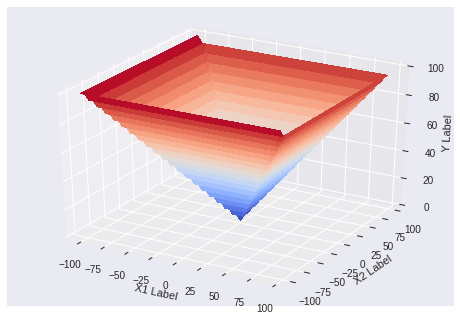

In [138]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import random

def fun(x1, x2):
  return max(abs(x1),abs(x2))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-100.0, 100.0, 5)
X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)


ax.set_xlabel('X1 Label')
ax.set_ylabel('X2 Label')
ax.set_zlabel('Y Label')


plt.show()

In [0]:
def run_all_combos2(maxGens, algo, successful):
    
    i = 0  
    
    ss = time.time()
    success = [0]*32  
    res_gen = [0]*32 
    first_min = [0]*32  
    time_taken = [0.0]*32  
    evals_needed = [0]*32  
    evals_total = [0]*32  
    minimum = [1000.0]*32  
    
    for c_indpb in [0.4, 0.05]:  
        for m_indpb in [0.3, 0.01]: 
            for tour in [3, 10]:
                
                toolbox = base.Toolbox()
                toolbox.register("attr_real", random.uniform, -100, 100)
                toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
                toolbox.register("population", tools.initRepeat, list, toolbox.individual)
                toolbox.register( "evaluate", evalYFunc2)
                toolbox.decorate( "evaluate", tools.DeltaPenality (feasible2, PENALTY_DELTA, distance2))
                pop_start = toolbox.population(n=POPULATION)
                hof = tools.HallOfFame(1)
                stats = tools.Statistics(lambda ind: ind.fitness.values)
                stats.register("avg", np.mean)
                stats.register("min", np.min)
                stats.register("max", np.max)
                toolbox.register("mutate", tools.mutGaussian, mu = 0, sigma=1.0, indpb=m_indpb)
                toolbox.register("mate", tools.cxUniform, indpb = c_indpb)
                toolbox.register( "select", tools.selTournament, tournsize=tour)
                
               
                start = time.time()
                if(algo == 'SimpleGA'): pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M + L'): pop, logbook = algorithms.eaMuPlusLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M, L'): pop, logbook = algorithms.eaMuCommaLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                stop = time.time()
                time_taken[i] = stop-start
               
                
                if(evalYFunc2(*hof)[0] <= successful):
                    success[i] += 1
                for j in range(maxGens-1, -1, -1):  
                    evals_total[i] += logbook[j]['nevals']  
                    if(logbook[j]['min'] <= successful):
                        res_gen[i] = j+1  
                        first_min[i] = logbook[j]['min']
                for j in range(res_gen[i]): 
                    evals_needed[i] += logbook[j]['nevals']
                minimum[i] = evalYFunc2(*hof)[0]
                i += 1
        for m_indpb in [0.3, 0.01]:  
            for tour in [3, 10]:  
                
                toolbox = base.Toolbox()
                toolbox.register("attr_real", random.uniform, -100, 100)
                toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
                toolbox.register("population", tools.initRepeat, list, toolbox.individual)
                toolbox.register( "evaluate", evalYFunc2)
                toolbox.decorate( "evaluate", tools.DeltaPenality (feasible2, PENALTY_DELTA, distance2))
                pop_start = toolbox.population(n=POPULATION)
                hof = tools.HallOfFame(1)
                stats = tools.Statistics(lambda ind: ind.fitness.values)
                stats.register("avg", np.mean)
                stats.register("min", np.min)
                stats.register("max", np.max)
                toolbox.register("mutate", tools.mutShuffleIndexes, indpb=m_indpb)
                toolbox.register("mate", tools.cxUniform, indpb = c_indpb)
                toolbox.register( "select", tools.selTournament, tournsize=tour)
                
                 
                start = time.time()
                if(algo == 'SimpleGA'): pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M + L'): pop, logbook = algorithms.eaMuPlusLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M, L'): pop, logbook = algorithms.eaMuCommaLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                stop = time.time()
                time_taken[i] = stop-start
               
                
                if(evalYFunc2(*hof)[0] <= successful):
                    success[i] += 1
                for j in range(maxGens-1, -1, -1):  
                    evals_total[i] += logbook[j]['nevals']  
                    if(logbook[j]['min'] <= successful):
                        res_gen[i] = j+1  
                        first_min[i] = logbook[j]['min']
                for j in range(res_gen[i]):  
                    evals_needed[i] += logbook[j]['nevals']
                minimum[i] = evalYFunc2(*hof)[0]
                i += 1
    for c_alpha in [0.5, 0.1]:  
        for m_indpb in [0.3, 0.01]:  
            for tour in [3, 10]:  
               
                toolbox = base.Toolbox()
                toolbox.register("attr_real", random.uniform, -100, 100)
                toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
                toolbox.register("population", tools.initRepeat, list, toolbox.individual)
                toolbox.register( "evaluate", evalYFunc2)
                toolbox.decorate( "evaluate", tools.DeltaPenality (feasible2, PENALTY_DELTA, distance2))
                pop_start = toolbox.population(n=POPULATION)
                hof = tools.HallOfFame(1)
                stats = tools.Statistics(lambda ind: ind.fitness.values)
                stats.register("avg", np.mean)
                stats.register("min", np.min)
                stats.register("max", np.max)
                toolbox.register("mutate", tools.mutGaussian, mu = 0, sigma=1.0, indpb=m_indpb)
                toolbox.register("mate", tools.cxBlend, alpha = c_alpha)
                toolbox.register( "select", tools.selTournament, tournsize=tour)
                
                 
                start = time.time()
                if(algo == 'SimpleGA'): pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M + L'): pop, logbook = algorithms.eaMuPlusLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M, L'): pop, logbook = algorithms.eaMuCommaLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                stop = time.time()
                time_taken[i] = stop-start
               
                
                if(evalYFunc2(*hof)[0] <= successful):
                    success[i] += 1
                for j in range(maxGens-1, -1, -1):  
                    evals_total[i] += logbook[j]['nevals'] 
                    if(logbook[j]['min'] <= successful):
                        res_gen[i] = j+1  
                        first_min[i] = logbook[j]['min']
                for j in range(res_gen[i]):  
                    evals_needed[i] += logbook[j]['nevals']
                minimum[i] = evalYFunc2(*hof)[0]
                i += 1
        for m_indpb in [0.3, 0.01]:  
            for tour in [3, 10]: 
                
                toolbox = base.Toolbox()
                toolbox.register("attr_real", random.uniform, -100, 100)
                toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
                toolbox.register("population", tools.initRepeat, list, toolbox.individual)
                toolbox.register( "evaluate", evalYFunc2)
                toolbox.decorate( "evaluate", tools.DeltaPenality (feasible2, PENALTY_DELTA, distance2))
                pop_start = toolbox.population(n=POPULATION)
                hof = tools.HallOfFame(1)
                stats = tools.Statistics(lambda ind: ind.fitness.values)
                stats.register("avg", np.mean)
                stats.register("min", np.min)
                stats.register("max", np.max)
                toolbox.register("mutate", tools.mutShuffleIndexes, indpb=m_indpb)
                toolbox.register("mate", tools.cxBlend, alpha = c_alpha)
                toolbox.register( "select", tools.selTournament, tournsize=tour)
                
                
                start = time.time()
                if(algo == 'SimpleGA'): pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M + L'): pop, logbook = algorithms.eaMuPlusLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                if(algo == 'M, L'): pop, logbook = algorithms.eaMuCommaLambda(pop_start, toolbox, mu=POPULATION//5, lambda_=4*POPULATION//5, cxpb=0.7, mutpb=0.3, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
                stop = time.time()
                time_taken[i] = stop-start
                
                
                if(evalYFunc2(*hof)[0] <= successful):
                    success[i] += 1
                for j in range(maxGens-1, -1, -1): 
                    evals_total[i] += logbook[j]['nevals'] 
                    if(logbook[j]['min'] <= successful):
                        res_gen[i] = j+1  
                for j in range(res_gen[i]):  
                    evals_needed[i] += logbook[j]['nevals']
                minimum[i] = evalYFunc2(*hof)[0]
                i += 1
    print ('{}, time: {}'.format(algo, time.time()-ss))
    return success, res_gen, first_min, time_taken, evals_needed, evals_total, minimum

In [140]:
from operator import add

MAX_ROUNDS = 10  
MAX_GENS = 50 
DELTA = 0.00001  
MINIMUM = 0

for algo in ['SimpleGA', 'M + L', 'M, L']:
    Successes = [0]*32
    Generations_Needed = [0]*32
    First_Minimums = [0]*32
    Average_Time = [0]*32
    Average_Success_Evals = [0]*32
    Average_Evals = [0]*32
    Average_Minimum = [0]*32
    
    #run all rounds
    for i in range(MAX_ROUNDS):
        successes, generations_needed, first_minimums, time_taken, evals_needed, evals_total, minimums = run_all_combos2(maxGens=MAX_GENS, algo=algo, successful=MINIMUM+DELTA)
        Successes = list(map(add, successes, Successes))
        Generations_Needed = list(map(add, generations_needed, Generations_Needed))
        First_Minimums = list(map(add, first_minimums, First_Minimums))
        Average_Time = list( map(add, time_taken, Average_Time))
        Average_Success_Evals = list(map(add, evals_needed, Average_Success_Evals))
        Average_Evals = list(map(add, evals_total, Average_Evals))
        Average_Minimum = list(map(add, minimums, Average_Minimum))
    for x in range(11):
        if(Generations_Needed[x] == 0):  
            Generations_Needed[x] = None
            First_Minimums[x] = None
            Average_Success_Evals[x] = None
        else:
            Generations_Needed[x] = Generations_Needed[x] / Successes[x]
            First_Minimums[x] = First_Minimums[x] / Successes[x]
            Average_Success_Evals[x] = Average_Success_Evals[x] / Successes[x]
    Average_Minimum = [y/MAX_ROUNDS for y in Average_Minimum]
    Average_Time = [y/MAX_ROUNDS for y in Average_Time]
    Average_Evals = [y/MAX_ROUNDS for y in Average_Evals]
    
    print ("\n{}:\n".format(algo))
    print ("{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}".format("Combination", "Successes", "Avg Minimums", "Avg Gens Needed", "Avg Success Evals", "Avg Total Evals", "Avg First Minimum", "Avg Time"))
    print ('-'*155)
    for i in range(32):
        print ("{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}".format(str(i), str(Successes[i]), str(Average_Minimum[i]), str(Generations_Needed[i]), str(Average_Success_Evals[i]), str(Average_Evals[i]), str(First_Minimums[i]), str(Average_Time[i])))
    print ("")        

SimpleGA, time: 1.90111398697
SimpleGA, time: 1.89827418327
SimpleGA, time: 1.91175913811
SimpleGA, time: 1.89863801003
SimpleGA, time: 1.89031291008
SimpleGA, time: 1.88547086716
SimpleGA, time: 1.89633584023
SimpleGA, time: 1.89933609962
SimpleGA, time: 1.89816594124
SimpleGA, time: 1.89479112625

SimpleGA:

Combination         Successes           Avg Minimums        Avg Gens Needed     Avg Success Evals   Avg Total Evals     Avg First Minimum   Avg Time            
-----------------------------------------------------------------------------------------------------------------------------------------------------------
0                   0                   4.08179228199       None                None                717                 None                0.0568499803543     
1                   0                   3.95546195925       None                None                721                 None                0.0650445461273     
2                   0                   10.670160

## Συμπεράσματα

Ξεκινάμε την ίδια διαδικασία με το μέρος 1 στην αρχη με DELTA=0.01 και μειώνουμε ψάχνοντας την βέλτιστη στρατιγικη σε συνδυασμό με τις βέλτιστες παραμέτρους:

Αρχικά παρατηρούμε ότι ήδη για DELTA=0.01 οι στρατηγικές M+L και M,L έχουν μηδενικές επιτυχίες , πόσο μάλλον όταν οι απαιτήσεις στην ακρίβεια θα αυξηθούν περισσοτερο , επομένως δεν θα αναλύσουμε καθόλου τα αποτελέσματα απο αυτές τις 2 στρατηγικές και θα επικεντρωθούμε στα αποτελεσματα της SimpleGA

DELTA=0.01:

Οι μόνοι αξιολογοι συνδυασμοι είναι οι 20,21 και 28

__________________________________________________________________________________________________________________________

DELTA=0.001:
 
Ο μόνος αξιολογος συνδυασμος είναι ο 20 με 5 επιτυχίες

__________________________________________________________________________________________________________________________

DELTA=0.0001:
 
Ο μόνος αξιολογος συνδυασμος είναι ο 20 με 3 επιτυχίες

__________________________________________________________________________________________________________________________


DELTA=0.00001:
 
Ο συνδυασμός 20 είχε 4 επιτυχίες και βλέπουμε ότι έχει μια συνέπεια στο να ξεχωρίζει από τις υπόλοιπες 

!!!
Οπότε οδηγούμε στο να επιλέξουμε την σταρτιγική SimpleGA με τον 20ο συνδυασμό , δηλαδή οι παράμετροι crossover = cxBlend, alpha = 0.1, mutate = mutShuffleIndexes, indpb = 0.3, toursize = 10
!!!

In [0]:
POPULATION2 = 40

def run_all_simpleGAs2(maxGens, cxpb, mutpb, successful):
    success = 0
    evals_total = 0
    res_gen = 0
    first_min = 0
    evals_needed = 0
    toolbox = base.Toolbox()
    toolbox.register("attr_real", random.uniform, -100.0, 100.0)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register( "evaluate", evalYFunc2)
    toolbox.decorate( "evaluate", tools.DeltaPenality (feasible2, PENALTY_DELTA, distance2))
    pop_start = toolbox.population(n=POPULATION2)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.3)
    toolbox.register("mate", tools.cxBlend, alpha = 0.1)
    toolbox.register( "select", tools.selTournament, tournsize=10)
    
    start = time.time()
    pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=maxGens, stats=stats, halloffame=hof, verbose=VERBOSE)
    stop = time.time()
    time_taken = stop-start
    
    
    if(evalYFunc2(*hof)[0] <= successful):
        success = 1
    for j in range(maxGens-1, -1, -1):  
        evals_total += logbook[j]['nevals']
        if(logbook[j]['min'] <= successful):
            res_gen = j+1
            first_min = logbook[j]['min']
    for j in range(res_gen):
        evals_needed += logbook[j]['nevals']
    minimum = evalYFunc2(*hof)[0]
    return success, res_gen, first_min, time_taken, evals_needed, evals_total, minimum

In [150]:
MAX_ROUNDS2 = 25
MAX_GENS2 = 25
DELTA2 = 0.00000001
MINIMUM = 0.0

Successes = [0]*18
Generations_Needed = [0]*18
First_Minimums = [0]*18
Average_Time = [0]*18
Average_Success_Evals = [0]*18
Average_Evals = [0]*18
Average_Minimum = [0]*18

j = 0  
for cxpb in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    ss = time.time()
    mutpb = 1.0 - cxpb  
    for i in range(MAX_ROUNDS2):  
        successes, generations_needed, first_minimums, time_taken, evals_needed, evals_total, minimums = run_all_simpleGAs2(maxGens=MAX_GENS2, cxpb=cxpb, mutpb=mutpb, successful=MINIMUM+DELTA2)
        Successes[j] += successes
        Generations_Needed[j] += generations_needed
        First_Minimums[j] += first_minimums
        Average_Time[j] += time_taken
        Average_Success_Evals[j] += evals_needed
        Average_Evals[j] += evals_total
        Average_Minimum[j] += minimums
    if(Generations_Needed[j] == 0):
        Generations_Needed[j] = None
        First_Minimums[j] = None
        Average_Success_Evals[j] = None
    else:
        Generations_Needed[j] = Generations_Needed[j] / Successes[j]
        First_Minimums[j] = First_Minimums[j] / Successes[j]
        Average_Success_Evals[j] = Average_Success_Evals[j] / Successes[j]
    Average_Minimum[j] = Average_Minimum[j]/MAX_ROUNDS2
    Average_Time[j] = Average_Time[j]/MAX_ROUNDS2
    Average_Evals[j] = Average_Evals[j]/MAX_ROUNDS2
    j += 1
    print ("time: {}".format(time.time()-ss))

print ("{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}".format("Combination", "Successes", "Avg Minimums", "Avg Gens Needed", "Avg Success Evals", "Avg Total Evals", "Avg First Minimum", "Avg Time"))
print ('-'*155)
for j in range(18):
    print ("{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}".format(str(j), str(Successes[j]), str(Average_Minimum[j]), str(Generations_Needed[j]), str(Average_Success_Evals[j]), str(Average_Evals[j]), str(First_Minimums[j]), str(Average_Time[j])))
print ("")
    

time: 1.71389603615
time: 1.69301199913
time: 1.68710494041
time: 1.67822098732
time: 1.6705520153
time: 1.66354179382
time: 1.64904499054
time: 1.65769910812
time: 1.64577293396
time: 1.6417620182
time: 1.65493297577
time: 1.65003204346
time: 1.64674592018
time: 1.66289782524
time: 1.68427991867
time: 1.69458794594
time: 1.69538807869
time: 1.70727396011
Combination         Successes           Avg Minimums        Avg Gens Needed     Avg Success Evals   Avg Total Evals     Avg First Minimum   Avg Time            
-----------------------------------------------------------------------------------------------------------------------------------------------------------
0                   0                   3.41117931568       None                None                954                 None                0.0681351280212     
1                   0                   4.04855022258       None                None                912                 None                0.0673014831543     
2  

Έπειτα απο διάφορες δοκιμές καταλήγουμε στο DELTA=0.00000001 και με καλύτερο συνδυασμό τον 17ο καθώς αυτός μας προσφέρει το ελάχιστο avg minimum και επίσης δίνει καλύτερα αποτελέσματα στο επόμενο βήμα οπότε έχουμε cxpb=0.9 kai mutpb=0.1

In [143]:
POPULATION3 = 100
MAX_GENS = 1000
MINIMUM = 0.0

total_evaluations = 0
toolbox = base.Toolbox()
toolbox.register("attr_real", random.uniform, -100.0, 100.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register( "evaluate", evalYFunc2)
toolbox.decorate( "evaluate", tools.DeltaPenality (feasible2, PENALTY_DELTA, distance2))
pop_start = toolbox.population(n=POPULATION3)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.3)
toolbox.register("mate", tools.cxBlend, alpha = 0.1)
toolbox.register( "select", tools.selTournament, tournsize=10)


start = time.time()
pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=0.9, mutpb=0.1, ngen=MAX_GENS, stats=stats, halloffame=hof, verbose=VERBOSE)
stop = time.time()
time_t = stop-start

for j in range(MAX_GENS):
    total_evaluations += logbook[j]['nevals']

print ("[x1, x2]={}, min(f(x1, x2))={}".format(str(hof), str(evalYFunc2(*hof)[0])))
print ("distance from optimal={}".format(str(abs(evalYFunc2(*hof)[0]-MINIMUM))))
print ("time taken={}".format(str(time_t)))
print ("total evaluations={}".format(str(total_evaluations)))

[x1, x2]=[[-7.452555114789492e-26, -7.452555114789492e-26]], min(f(x1, x2))=7.45255511479e-26
distance from optimal=7.45255511479e-26
time taken=6.4423699379
total evaluations=91051


Παρατηρούμε μια διαφορά στην ακρίβεια συγκριτικά με την προηγούμενη μας συνάρτηση , παρόλα αυτά με την αύξηση του POPULATION και του MAX_GENS πχ(1000,5000) το αποτέλεσμα θα έχει τεράστια ακρίβεια που θα θεωρηθεί 0 το αποτέλεσμα παρόλα αυτά παίρνει πολύ χρόνο

### Για D=1, 10, 20, 40 και μεγαλύτερες διαστάσεις


In [0]:
import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools


def evalY(ind):
    Y = -1.0
    for item in range(len(ind)):
        if(abs(ind[item])>Y):
            Y=abs(ind[item])
    return (Y, )

def feasible3(indiv):
    min_bound = np.array([-100]*len(indiv))
    max_bound = np.array([100]*len(indiv))
    if any( indiv < min_bound) or any( indiv > max_bound):
        return False
    return True


def distance3(indiv) :
    dist = 0.0
    min_bound = np.array([-100]*len(indiv))
    max_bound = np.array([100]*len(indiv))
    for i in range (len( indiv )) :
        penalty = 0
        if ( indiv [i] < min_bound[i]) : penalty = -100 - indiv [i]
        if ( indiv [i] > max_bound[i]) : penalty = indiv [i] - 100
        if (NUMVARIABLES > 10): penalty = penalty/2
        if (NUMVARIABLES >= 50): penalty = penalty/2
        dist = dist + penalty
    return dist


In [0]:
def run_final_combo(maxGens, algo, successful, numVariables):
    
    i = 0  
    ss = time.time()
    success = [0]  
    res_gen = [0]  
    first_min = [0]  
    time_taken = [0.0] 
    evals_needed = [0]  
    evals_total = [0]  
    minimum = [1000.0]  
    

    
    toolbox = base.Toolbox()
    toolbox.register("attr_real", random.uniform, -100, 100)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register( "evaluate", evalY)
    toolbox.decorate( "evaluate", tools.DeltaPenality (feasible3, PENALTY_DELTA, distance3))
    pop_start = toolbox.population(n=POPULATION)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.3)
    toolbox.register("mate", tools.cxBlend, alpha = 0.1)
    toolbox.register("select",tools.selTournament, tournsize=10 )

    
    start = time.time()
    if(algo == 'SimpleGA'): pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=0.9, mutpb=0.1, ngen=maxGens, stats=stats, halloffame=hof,verbose=VERBOSE)
    stop = time.time()
    time_taken[i] = stop-start
    

    if(evalY(*hof)[0] <= successful):
        success[i] += 1
    for j in range(maxGens-1, -1, -1):  
        evals_total[i] += logbook[j]['nevals']  
        if(logbook[j]['min'] <= successful):
            res_gen[i] = j+1 
            first_min[i] = logbook[j]['min']
    for j in range(res_gen[i]): 
        evals_needed[i] += logbook[j]['nevals']
    minimum[i] = evalY(*hof)[0]
    i += 1

    return success, res_gen, first_min, time_taken, evals_needed, evals_total, minimum

In [146]:
from operator import add

MAX_ROUNDS = 10  
POPULATION = 100
MAX_GENS = 200
MINIMUM = 0
DELTA = [0.000001,0.00001,0.0001,0.001,0.001]
r = 0

for num_var in [2,10,20,40,100]:
    NUMVARIABLES = num_var
    DELTA_TEMP = DELTA[r]
    r += 1
   
    Successes = [0]
    Generations_Needed = [0]
    First_Minimums = [0]
    Average_Time = [0]
    Average_Success_Evals = [0]
    Average_Evals = [0]
    Average_Minimum = [0]
    
    
    for i in range(MAX_ROUNDS):
        successes, generations_needed, first_minimums, time_taken, evals_needed, evals_total, minimums = run_final_combo(maxGens=MAX_GENS, algo='SimpleGA', successful=MINIMUM+DELTA_TEMP, numVariables=num_var)
        Successes = map(add, successes, Successes)
        Generations_Needed = map(add, generations_needed, Generations_Needed)
        First_Minimums = map(add, first_minimums, First_Minimums)
        Average_Time = map(add, time_taken, Average_Time)
        Average_Success_Evals = map(add, evals_needed, Average_Success_Evals)
        Average_Evals = map(add, evals_total, Average_Evals)
        Average_Minimum = map(add, minimums, Average_Minimum)
    for x in range(0):
        if(Generations_Needed[x] == 0):  
            Generations_Needed[x] = None
            First_Minimums[x] = None
            Average_Success_Evals[x] = None
        else:
            Generations_Needed[x] = Generations_Needed[x] / Successes[x]
            First_Minimums[x] = First_Minimums[x] / Successes[x]
            Average_Success_Evals[x] = Average_Success_Evals[x] / Successes[x]
    Average_Minimum = [y/MAX_ROUNDS for y in Average_Minimum]
    Average_Time = [y/MAX_ROUNDS for y in Average_Time]
    Average_Evals = [y/MAX_ROUNDS for y in Average_Evals]
    if (num_var == 2):
        print "{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}".format("D", "Successes", "Avg Minimums", "Avg Gens Needed", "Avg Success Evals", "Avg Total Evals", "Avg First Minimum", "Avg Time")
        print '-'*155
    for i in range(1):
        print "{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}".format(num_var, Successes[i], Average_Minimum[i], Generations_Needed[i], Average_Success_Evals[i], Average_Evals[i], First_Minimums[i], Average_Time[i])
    print ""  

D                   Successes           Avg Minimums        Avg Gens Needed     Avg Success Evals   Avg Total Evals     Avg First Minimum   Avg Time            
-----------------------------------------------------------------------------------------------------------------------------------------------------------
2                   10                  5.07285064634e-09   157                 14369               18180               6.02597763748e-06   1.36456141472       

10                  0                   0.98583312113       0                   0                   18243               0                   1.78732841015       

20                  0                   60.1864207337       0                   0                   18223               0                   2.4076636076        

40                  0                   42.0807403743       0                   0                   18194               0                   3.6164648056        

100                 0              

## Σχολιασμοί

- Παρατηρούμε ότι για μεγάλες διαστάσεις η στρατιγική μας δεν αποδίδει καθόλου καλά συγκριτικά με τις 2 διαστάσεις


- Αυτό ίσως να οφείλεται στο γεγονός οτι οι παράμετροι που διαλέξαμε να μην μπορούν να εφαρμοστούν στις πολλές διαστασεις


- Παρατηρούμε ότι όσο μεγαλώνουν οι διαστάσεις τόσο  χειρτορεύει και ο μέσος minimum


- Μια βελτίωση που πραγματοποιούμε και έχει άμεση εφαρμογή στον avg minimum είναι η πολυκριτιριακή βελτιστοποίηση (NSGA-II)


In [0]:
def run_final_combo1(maxGens, algo, successful, numVariables):
    
    i = 0  
    ss = time.time()
    success = [0]  
    res_gen = [0]  
    first_min = [0]  
    time_taken = [0.0] 
    evals_needed = [0]  
    evals_total = [0]  
    minimum = [1000.0]  
    

    
    toolbox = base.Toolbox()
    toolbox.register("attr_real", random.uniform, -100, 100)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, numVariables)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register( "evaluate", evalY)
    toolbox.decorate( "evaluate", tools.DeltaPenality (feasible3, PENALTY_DELTA, distance3))
    pop_start = toolbox.population(n=POPULATION)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.3)
    toolbox.register("mate", tools.cxBlend, alpha = 0.1)
    toolbox.register("select",tools.selNSGA2 )


    start = time.time()
    if(algo == 'SimpleGA'): pop, logbook = algorithms.eaSimple(pop_start, toolbox, cxpb=0.9, mutpb=0.1, ngen=maxGens, stats=stats, halloffame=hof,verbose=VERBOSE)
    stop = time.time()
    time_taken[i] = stop-start
    

    if(evalY(*hof)[0] <= successful):
        success[i] += 1
    for j in range(maxGens-1, -1, -1):  
        evals_total[i] += logbook[j]['nevals']  
        if(logbook[j]['min'] <= successful):
            res_gen[i] = j+1  
            first_min[i] = logbook[j]['min']
    for j in range(res_gen[i]):  
        evals_needed[i] += logbook[j]['nevals']
    minimum[i] = evalY(*hof)[0]
    i += 1

    return success, res_gen, first_min, time_taken, evals_needed, evals_total, minimum

In [0]:
def func(a,b,c):
    MAX_ROUNDS = a  
    POPULATION = b
    MAX_GENS = c
    MINIMUM = 0
    DELTA = [0.000001,0.00001,0.0001,0.001,0.001]
    r = 0

    for num_var in [2,10,20,40,100]:
        NUMVARIABLES = num_var
        DELTA_TEMP = DELTA[r]
        r += 1

        Successes = [0]
        Generations_Needed = [0]
        First_Minimums = [0]
        Average_Time = [0]
        Average_Success_Evals = [0]
        Average_Evals = [0]
        Average_Minimum = [0]


        for i in range(MAX_ROUNDS):
            successes, generations_needed, first_minimums, time_taken, evals_needed, evals_total, minimums = run_final_combo1(maxGens=MAX_GENS, algo='SimpleGA', successful=MINIMUM+DELTA_TEMP, numVariables=num_var)
            Successes = map(add, successes, Successes)
            Generations_Needed = map(add, generations_needed, Generations_Needed)
            First_Minimums = map(add, first_minimums, First_Minimums)
            Average_Time = map(add, time_taken, Average_Time)
            Average_Success_Evals = map(add, evals_needed, Average_Success_Evals)
            Average_Evals = map(add, evals_total, Average_Evals)
            Average_Minimum = map(add, minimums, Average_Minimum)
        for x in range(0):
            if(Generations_Needed[x] == 0):  
                Generations_Needed[x] = None
                First_Minimums[x] = None
                Average_Success_Evals[x] = None
            else:
                Generations_Needed[x] = Generations_Needed[x] / Successes[x]
                First_Minimums[x] = First_Minimums[x] / Successes[x]
                Average_Success_Evals[x] = Average_Success_Evals[x] / Successes[x]
        Average_Minimum = [y/MAX_ROUNDS for y in Average_Minimum]
        Average_Time = [y/MAX_ROUNDS for y in Average_Time]
        Average_Evals = [y/MAX_ROUNDS for y in Average_Evals]
        if (num_var == 2):
            print "{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}".format("D", "Successes", "Avg Minimums", "Avg Gens Needed", "Avg Success Evals", "Avg Total Evals", "Avg First Minimum", "Avg Time")
            print '-'*155
        for i in range(1):
            print "{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}{:<20}".format(num_var, Successes[i], Average_Minimum[i], Generations_Needed[i], Average_Success_Evals[i], Average_Evals[i], First_Minimums[i], Average_Time[i])
        print ""  

In [149]:
func(10,100,200)

D                   Successes           Avg Minimums        Avg Gens Needed     Avg Success Evals   Avg Total Evals     Avg First Minimum   Avg Time            
-----------------------------------------------------------------------------------------------------------------------------------------------------------
2                   6                   0.000130988779757   482                 43842               18202               3.27644972499e-06   4.51422836781       

10                  0                   0.176763735943      0                   0                   18203               0                   5.18263137341       

20                  0                   0.771109115598      0                   0                   18221               0                   5.73144395351       

40                  0                   0.474140295676      0                   0                   18228               0                   6.71350190639       

100                 0              